# Import libraries

In [43]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from scipy import optimize


sns.set(style='white', context='notebook', palette='deep')

# Define RPS model

In [2]:
#Grid with dimensions h x v and cyclic i.e. i_0 = h*i and j_0 = v*j

def neighbour(i,j,h,v):
    neighbours = []
    if i != 0 and i != h-1:
        if j == 0:
            neighbours = [[i+1,j],[i-1,j],[i,j+1],[i,j+v-1]]
        if j == v-1:
            neighbours = [[i+1,j],[i-1,j],[i,j-v-1],[i,j-1]]
        else:
            neighbours = [[i+1,j],[i-1,j],[i,j+1],[i,j-1]]
    if i == 0:
        if j == 0:
            neighbours = [[i+1,j],[i+h-1,j],[i,j+1],[i,j+v-1]]
        if j == v-1:
            neighbours = [[i+1,j],[i+h-1,j],[i,j-v-1],[i,j-1]]
        else:
            neighbours = [[i+1,j],[i+h-1,j],[i,j+1],[i,j-1]]
    if i == h-1:
        if j == 0:
            neighbours = [[i-h-1,j],[i-1,j],[i,j+1],[i,j+v-1]]
        if j == v-1:
            neighbours = [[i-h-1,j],[i-1,j],[i,j-v-1],[i,j-1]]
        else:
            neighbours = [[i-h-1,j],[i-1,j],[i,j+1],[i,j-1]]
    return neighbours[np.random.choice(range(4))]

In [3]:
#Random selection of the point to aply an action

def action(m,r):
    return np.random.choice(range(3),p=[m,r,1-m-r])

In [4]:
#y 0 for classic or 1 for bilateral pr = pl. 
#Random selection of the action to take place and if this action is possible

def step(i,j,m,r,y,h,v):
    a = action(m,r)
    n = neighbour(i,j,h,v)
    pos = i * v + j
    npos = n[0] * v + n[1]
#mobilidade
    if a == 0:
        temp = grid[npos]
        grid[npos] = grid[pos]
        grid[pos] = temp
#reprodução
    if a == 1:
        if grid[pos] != 3:
            if grid[npos] == 3:
                grid[npos] = grid[pos]
#predação
    if a == 2:
        if y == 0:
            if grid[npos] != 3 and grid[pos] != 3:
                if grid[pos] == grid[npos] + 1:
                    grid[npos] = 3
                if grid[pos] == 0 and grid[npos] == 2:
                    grid[npos] = 3
        if y == 1:
            if grid[npos] != 3 and grid[pos] != 3:
                grid[npos] == 3        

In [38]:
#Save the grid and the number of empty points

def save(grid,i,j):
    with open('m_0/r07/grid_' + str(i) + '_' + str(j) + '.csv', 'wb') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_NONE)
        wr.writerow(grid)

def save2(empty,i,j):
    with open('m_0/r07/empty_' + str(i) + '_' + str(j) + '.csv', 'wb') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_NONE)
        wr.writerow(empty)

# Generate images

In [43]:
#Generates n (n = number_of_images) images with size h x v and save each 100^2 steps 
#(100^2 steps = 1 generation)

number_of_images = 10
while number_of_images < 60:
    h=100
    v=100
    grid = np.random.choice(4, h*v, p=[0.3, 0.3, 0.3, 0.1])
#grid_initial = grid
    time = 1*10**7
    counter = 0
    empty = []
    gen=[]
    while counter < time:
        i = np.random.choice(range(h))
        j = np.random.choice(range(v))
        step(i,j,0.0,0.7,0,h,v)
        if counter%(100000)==0:
            empty.append(1.0/np.count_nonzero(grid == 3))
            gen.append(counter/100000.0)
            save(grid,number,counter*1.0/10000)
            save2(empty,number,counter*1.0/10000)
        counter += 1
    number_of_images+= 1

In [14]:
#generate n initial grids

number = 0
while number < 1000:
    h=100
    v=100
    grid = np.random.choice(4, h*v, p=[0.3, 0.3, 0.3, 0.1])
#grid_initial = grid
    save('grids_initial/grids_initial',grid,number,0)
    number+= 1

# Load saved images

In [9]:
def load_data(var):
    temp2=[]
    with open(var+'.csv') as csvfile:
        temp = list(csv.reader(csvfile))
    for i in range(len(temp)):
        temp1=[]
        for j in range(len(temp[i])):
            temp1.append(float(temp[i][j]))
        temp2.append(temp1)
    return temp2 

# Print some example of grids

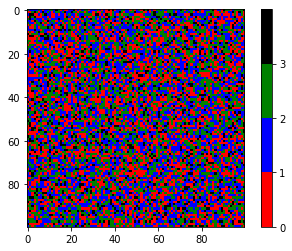

In [24]:
import matplotlib.pyplot as plt
from matplotlib import colors

grid_i = np.array(load_data('grids_initial/grids_initial2_0'))
cmap = colors.ListedColormap(['red', 'blue','green','black'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)
img = plt.imshow(grid_i.reshape(h,v), cmap=cmap, interpolation='none',norm=norm)
plt.colorbar(img, boundaries=bounds, ticks=[0, 1, 2, 3])

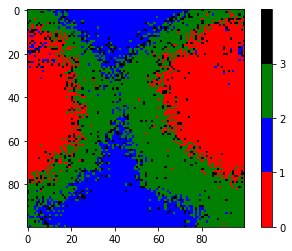

In [26]:
# Final grid with m = 0.5 and r = p = 0.25

grid = np.array(load_data('m_0_5/grids/grid_119_990.0'))
cmap = colors.ListedColormap(['red', 'blue','green','black'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)
img = plt.imshow(grid.reshape(h,v), cmap=cmap, interpolation='none',norm=norm)
plt.colorbar(img, boundaries=bounds, ticks=[0, 1, 2, 3])

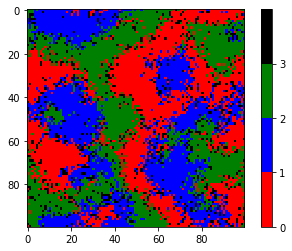

In [28]:
# Final grid with m = 0.3 and r = p = 0.35

grid = np.array(load_data('m_0_3/grids/grid_119_990.0'))
cmap = colors.ListedColormap(['red', 'blue','green','black'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)
img = plt.imshow(grid.reshape(h,v), cmap=cmap, interpolation='none',norm=norm)
plt.colorbar(img, boundaries=bounds, ticks=[0, 1, 2, 3])

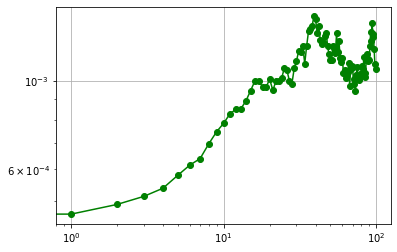

In [30]:
#Example of number of empty spaces evolution
#This often is used as an indicator of phase transition and stabolity on the system

emp = load_data('m_0_3/grids/empty_50_990.0')[0]
g = range(len(emp))
plt.plot(g, emp,'-o',color='g')
plt.xscale('log')
plt.yscale('log')
#plt.title('Simulation with Delphes')
plt.grid(True)
#plt.legend(loc='best') 
#plt.xlabel(r'$m_a \; [GeV]$', fontsize=15)
#plt.ylabel(r'$N_{x}/N_{total}$', fontsize=15)
plt.show()

# Train CNN

In [6]:
#Import initial and final grids to train

grids_i=[]
grids_f=[]
y_i=[]
y_f=[]

for i in range(120):
    for j in range(0,11,10):
        temp_i = load_data('m_0_5/grids/grid_' + str(i) + '_' + str(j) + '.0')[0]
        temp_f = load_data('m_0_5/grids/grid_' + str(i) + '_' + str(990-j) + '.0')[0]
        grids_i.append(temp_i)
        grids_f.append(temp_f)
        y_i.append(0)
        y_f.append(1)
print(len(grids_i))
print(len(y_i))

240
240


In [5]:
train = grids_i
y = list(y_i)

In [6]:
def join(t,y,grid,yt):
    for i in range(len(grid)):
        t.append(grid[i])
        y.append(yt[i])
    return t, y

In [7]:
join(train,y,grids_f,y_f)
print(len(train))

2640


In [8]:
for i in range(len(train)):
    train[i]=np.array(train[i]).reshape(100, 100, 1)
print(len(train))

2640


In [12]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train_value = y # keep the origianl label
y = to_categorical(y, num_classes = 2)
y.shape

(2640, 2)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train[0:], y, test_size=0.2)

In [14]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

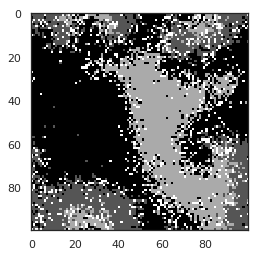

In [15]:
plt.imshow(x_train[10].reshape(100,100), cmap='gray', interpolation='none')

In [16]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (100, 100, 1), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

#Add dropout
classifier.add(Dropout(0.25))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.4))

# Step 3 - Flattening
classifier.add(Flatten())

In [17]:
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 2, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
epochs = 5
batch_size = 16

In [19]:
history = classifier.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,\
                                  verbose=1,validation_data=(x_val,y_val))

Train on 2112 samples, validate on 528 samples
Epoch 1/5
2112/2112 [==============================] - 61s 29ms/step - loss: 0.1595 - accuracy: 0.9295 - val_loss: 7.8898e-05 - val_accuracy: 1.0000
Epoch 2/5
2112/2112 [==============================] - 61s 29ms/step - loss: 1.0882e-06 - accuracy: 1.0000 - val_loss: 1.6688e-04 - val_accuracy: 1.0000
Epoch 3/5
2112/2112 [==============================] - 63s 30ms/step - loss: 6.1121e-07 - accuracy: 1.0000 - val_loss: 2.6396e-04 - val_accuracy: 1.0000
Epoch 4/5
2112/2112 [==============================] - 64s 30ms/step - loss: 4.4877e-07 - accuracy: 1.0000 - val_loss: 3.8211e-04 - val_accuracy: 1.0000
Epoch 5/5
2112/2112 [==============================] - 63s 30ms/step - loss: 3.5268e-07 - accuracy: 1.0000 - val_loss: 5.1315e-04 - val_accuracy: 1.0000


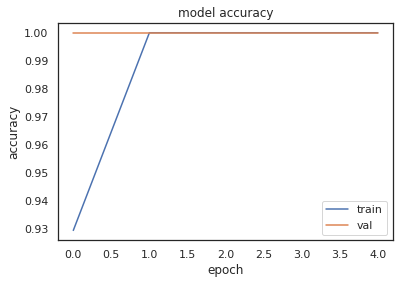

In [20]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.show()

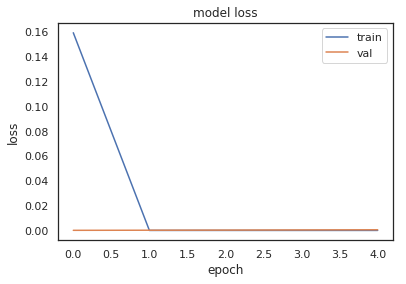

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim(0.0, 0.8)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()

In [24]:
#Save trained model

classifier.save('rps_classifier_m05')

In [38]:
#import saved model
import keras

reconstructed_model = keras.models.load_model('rps_classifier_m03')

# Using model to predict intermediate grids

In [39]:
#Classify between initial and final grids

final=[]
xfinal=[]

for k in range(0,580,10):
    grids_i=[]
    grids_f=[]
    y_i=[]
    y_f=[]

    for i in range(120):
        temp_i = load_data('m_0_3/grids/grid_' + str(i) + '_' + str(0+k) + '.0')[0]
        grids_i.append(temp_i)
        y_i.append(0)

    train2 = grids_i
    y2 = list(y_i)

    for i in range(len(train2)):
        train2[i]=np.array(train2[i]).reshape(100, 100, 1)

    x_train2 = np.array(train2)
    y_train2 = np.array(y2)

    x_train2.shape

    predicted_classes = reconstructed_model.predict(x_train2)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

    c=[]
    for i in range(len(predicted_classes)):
        if predicted_classes[i]==0:
            c.append(i)
    final.append(len(c)/120.)
    xfinal.append(k)
print(len(final))

58


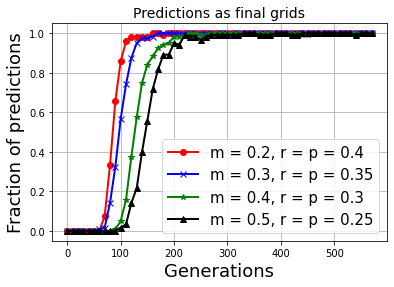

In [31]:
#Plot saved predictions

x=load_data('xfinal02')[0]
yf=load_data('final02')[0]
x2=load_data('xfinal03')[0]
yf2=load_data('final03')[0]
x4=load_data('xfinal04')[0]
yf4=load_data('final04')[0]
x3=load_data('xfinal05')[0]
yf3=load_data('final05')[0]
plt.plot(x,yf,'-o',label=r'm = 0.2, r = p = 0.4',color='r',linewidth=2)
plt.plot(x2,yf2,'-x',label=r'm = 0.3, r = p = 0.35',color='b',linewidth=2)
plt.plot(x4,yf4,'-*',label=r'm = 0.4, r = p = 0.3',color='g',linewidth=2)
plt.plot(x3,yf3,'-^',label=r'm = 0.5, r = p = 0.25',color='black',linewidth=2)
plt.xlabel(r'Generations', fontsize=18)
plt.ylabel(r'Fraction of predictions',fontsize=18)
plt.title(r'Predictions as final grids', fontsize=14)
plt.legend(loc='best', fontsize=15) 
plt.grid(True)
#plt.savefig('Breno/transition.pdf')

We can see above that the classifier works well to detect phase transitions in the RPS system for 
many sets of parameters, even indicating different values for each of them. 

In [20]:
empt=[]
for i in range(100):
    temp_i = load_data('m_0_5/grids/empty_' + str(i) + '_990.0')[0]
    empt.append(temp_i)

In [21]:
xempty=[]
empty_f=[]
for i in range(len(empt[0])):
    emp=0
    for j in range(len(empt)):
        emp+=empt[j][i]
    empty_f.append(emp/len(empt[0]))
    xempty.append(i*10)

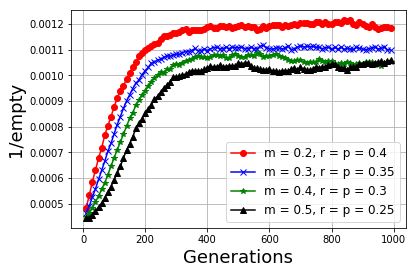

In [38]:
plt.plot(u2[1:],v2[1:],'-o',color='r',label=r'm = 0.2, r = p = 0.4')
plt.plot(u3[1:],v3[1:],'-x',color='b',label=r'm = 0.3, r = p = 0.35')
plt.plot(u4[1:],v4[1:],'-*',color='g',label=r'm = 0.4, r = p = 0.3')
plt.plot(u5[1:],v5[1:],'-^',color='black',label=r'm = 0.5, r = p = 0.25')

plt.xlabel('Generations', fontsize=18)
plt.ylabel('1/empty', fontsize=18)

plt.legend(loc='best', fontsize=12) 
plt.grid(True)
plt.savefig('Breno/empty.pdf')

Here we can see that the number of empty parameters also indicates the phase transition around the same 
point as the CNN model, but it is much less pronunciated.

# Print grids around the phase transiotion point

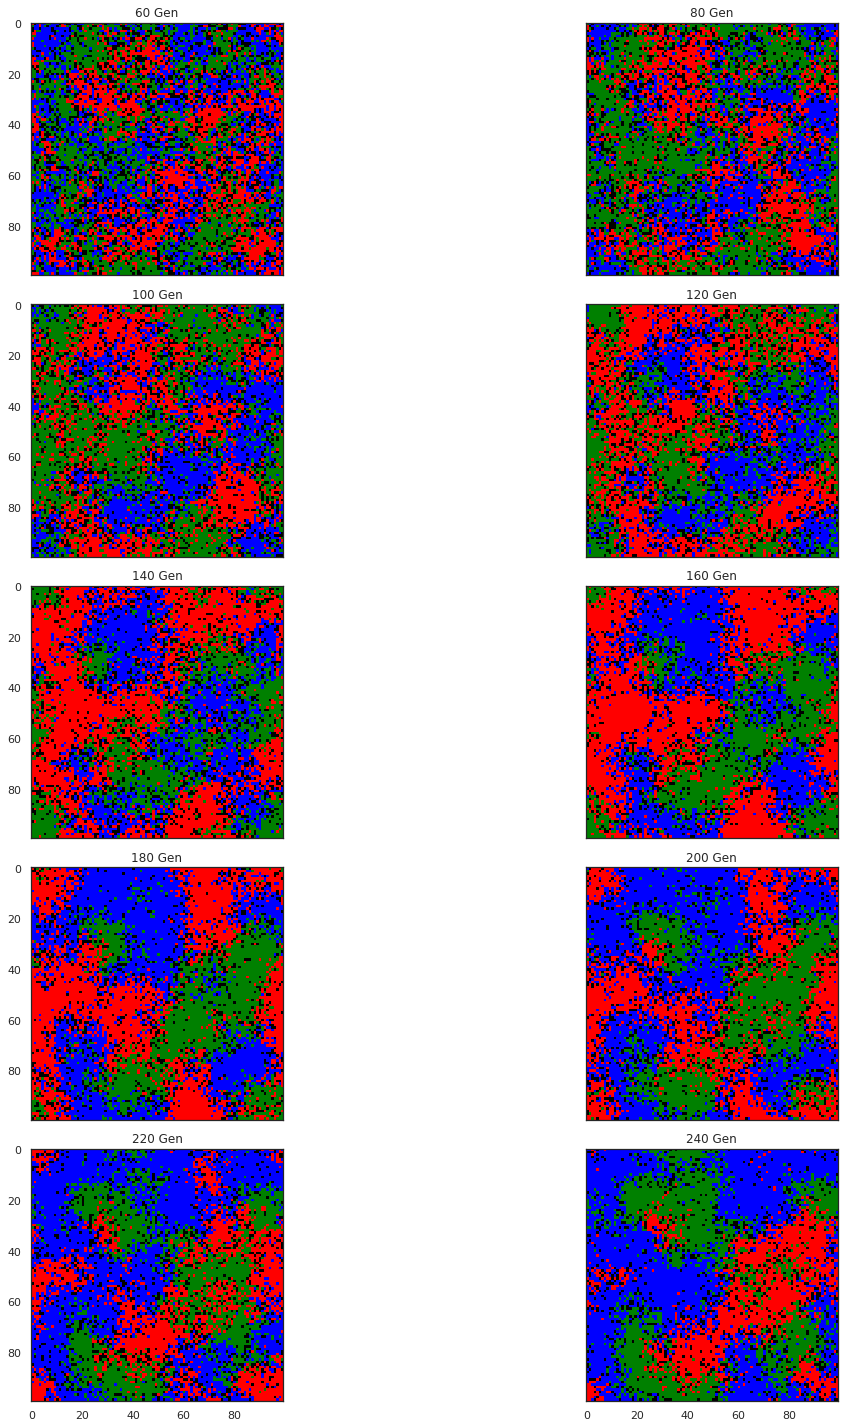

In [42]:
sample=[]
c = 60
while c < 241:
    emp = load_data('m_0_5/grids/grid_'+'40_'+str(c)+'.0')[0]
    sample.append(emp)
    c+=20


fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8),(ax9, ax10)) = plt.subplots(5, 2,figsize=(20,20))
cmap = colors.ListedColormap(['red', 'blue','green','black'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax1.imshow(np.array(sample[0]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax1.set_title('60 Gen')
#ax1.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3])
ax2.imshow(np.array(sample[1]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax2.set_title('80 Gen')
#ax2.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3])
ax3.imshow(np.array(sample[2]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax3.set_title('100 Gen')
#ax3.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3])
ax4.imshow(np.array(sample[3]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax4.set_title('120 Gen')
ax5.imshow(np.array(sample[4]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax5.set_title('140 Gen')
ax6.imshow(np.array(sample[5]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax6.set_title('160 Gen')
ax7.imshow(np.array(sample[6]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax7.set_title('180 Gen')
ax8.imshow(np.array(sample[7]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax8.set_title('200 Gen')
ax9.imshow(np.array(sample[8]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax9.set_title('220 Gen')
ax10.imshow(np.array(sample[9]).reshape(100,100), cmap=cmap, interpolation='none',norm=norm)
ax10.set_title('240 Gen')

for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"